In [3]:
# load the R packages
library(Seurat)
library(Matrix)
library(ggplot2)


In [ ]:
# Seurat有一个专有函数是读进10x的数据，你可以看看。
# load a single cell RNA-seq dataset
# example dataset download from: https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE216595
data_dir <- "/mnt/dfc_data2/project/linyusen/database/81_MORF/test_data/"
barcodes <- paste0(data_dir, "GSM6681046_180124_perturb_S8_barcodes.tsv.gz")
genes    <- paste0(data_dir, "GSM6681046_180124_perturb_S8_genes.tsv.gz")
matrix   <- paste0(data_dir, "GSM6681046_180124_perturb_S8_matrix.mtx.gz")

In [4]:
# preprocessing the dataset
counts <- readMM(matrix)
gene_names <- read.delim(genes, header = FALSE)
barcode_names <- read.delim(barcodes, header = FALSE)

# 添加行列名
rownames(counts) <- make.unique(gene_names$V1)  # 或 V2 如果有gene symbols
colnames(counts) <- barcode_names$V1

In [5]:
# create seurat scRNA-seq objects
seurat_obj <- CreateSeuratObject(counts = counts, project = "GSM6681046")

Warning message:
“Data is of class dgTMatrix. Coercing to dgCMatrix.”


In [7]:
expr_mat <- GetAssayData(seurat_obj, slot = "counts")
dense_mat <- as.matrix(expr_mat)

# # 保存为 TSV（不推荐 CSV，因为基因名中可能含逗号）
# write.table(dense_mat[1:1000, 1:500], file = "/mnt/dfc_data2/project/linyusen/database/81_MORF/test_data/single_cell/expression_matrix.tsv", sep = "\t", quote = FALSE, col.names = NA)

Warning message:
“The `slot` argument of `GetAssayData()` is deprecated as of SeuratObject 5.0.0.
ℹ Please use the `layer` argument instead.”
Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.5 GiB”


Normalizing layer: counts

Finding variable features for layer counts

Centering and scaling data matrix

PC_ 1 
Positive:  ENSG00000112306, ENSG00000108107, ENSG00000087086, ENSG00000133112, ENSG00000167996, ENSG00000173457, ENSG00000198755, ENSG00000169100, ENSG00000198034, ENSG00000034510 
	   ENSG00000197061, ENSG00000171858, ENSG00000205542, ENSG00000116649, ENSG00000177410, ENSG00000204628, ENSG00000148200, ENSG00000069482, ENSG00000103202, ENSG00000169750 
	   ENSG00000102119, ENSG00000116133, ENSG00000254934, ENSG00000181350, ENSG00000187840, ENSG00000269893, ENSG00000086475, ENSG00000230798, ENSG00000105426, ENSG00000189067 
Negative:  ENSG00000123416, ENSG00000080824, ENSG00000096384, ENSG00000117450, ENSG00000074800, ENSG00000111716, ENSG00000132780, ENSG00000075624, ENSG00000138385, ENSG00000196230 
	   ENSG00000170315, ENSG00000130203, ENSG00000041357, ENSG00000092621, ENSG00000144381, ENSG00000044574, ENSG00000067225, ENSG00000150753, ENSG00000167004, ENSG00000182481 
	  

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 10000
Number of edges: 311952

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8179
Number of communities: 9
Elapsed time: 1 seconds


Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”
11:01:05 UMAP embedding parameters a = 0.9922 b = 1.112

11:01:05 Read 10000 rows and found 20 numeric columns

11:01:05 Using Annoy for neighbor search, n_neighbors = 30

11:01:05 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

11:01:06 Writing NN index file to temp file /tmp/RtmpUal1oN/file5e971200e283a

11:01:06 Searching Annoy index using 1 thread, search_k = 3000

11:01:09 Annoy recall = 100%

11:01:10 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbors


   0    1    2    3    4    5    6    7    8 
2655 2112 1856  707  693  669  606  601  101 

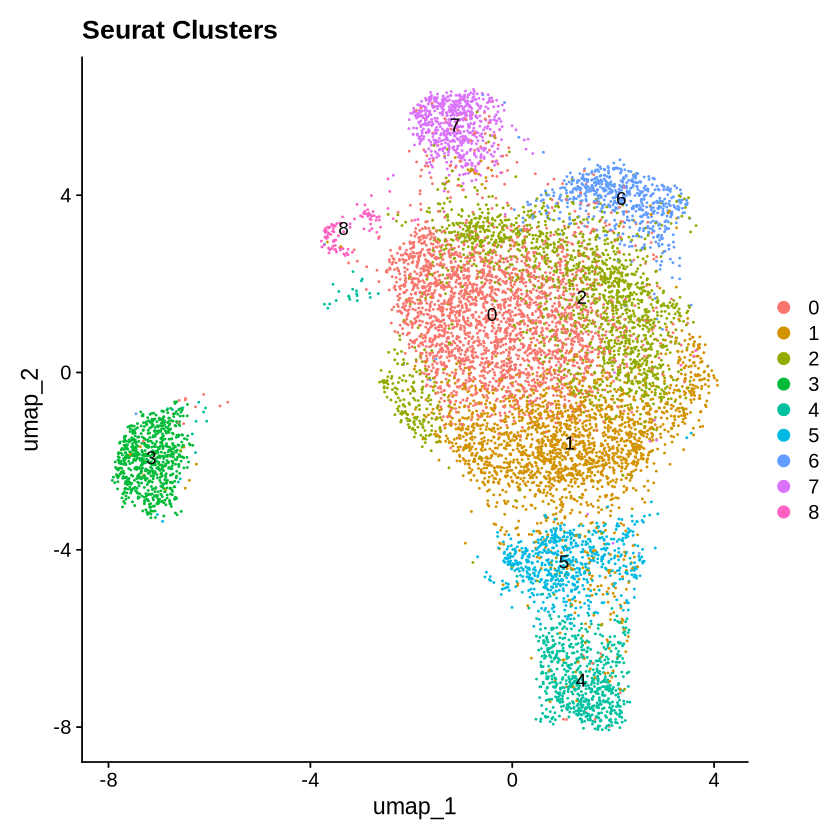

In [8]:
# 这个步骤还有很多是需要调整的。
# 假设你已经读入 count matrix 并创建 Seurat 对象
# seurat_obj <- CreateSeuratObject(counts = counts)

# 预处理：过滤、标准化、找高变基因
seurat_obj <- NormalizeData(seurat_obj)
seurat_obj <- FindVariableFeatures(seurat_obj, selection.method = "vst", nfeatures = 2000)

# PCA 降维
seurat_obj <- ScaleData(seurat_obj)
seurat_obj <- RunPCA(seurat_obj, features = VariableFeatures(object = seurat_obj))

# 邻接图 + 聚类
seurat_obj <- FindNeighbors(seurat_obj, dims = 1:20)
seurat_obj <- FindClusters(seurat_obj, resolution = 0.5)  # 分辨率可调，0.4~1 常见

# UMAP 可视化
seurat_obj <- RunUMAP(seurat_obj, dims = 1:20)

# 绘图：UMAP + 聚类标注
DimPlot(seurat_obj, reduction = "umap", label = TRUE) + ggtitle("Seurat Clusters")

# 6查看聚类结果
table(seurat_obj$seurat_clusters)

In [34]:
# mapping TF over-expression to single cells
library(dplyr)
library(readr)
# 1. 读取 TF 映射表
tf_map <- read_csv("/mnt/dfc_data2/project/linyusen/database/81_MORF/test_data/GSM6681047_180124_TFmap.csv.gz", col_names = c("barcode", "TF"))
# 2. 检查 barcode 格式（是否需要补 "-1"）
head(colnames(seurat_obj))  # 比如：AAACCTGCACGCGAAA-1

# 如果 Seurat 中带后缀 "-1"，就也给 TFmap 补上
tf_map$barcode <- paste0(tf_map$barcode, "-1")
tf_map

Rows: 76234 Columns: 2
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (2): barcode, TF

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


[1] "AAACCTGAGAATTCCC-1" "AAACCTGCACAAGTAA-1" "AAACCTGCACGCGAAA-1"
[4] "AAACCTGCATGTCCTC-1" "AAACCTGCATTCGACA-1" "AAACCTGGTAGTAGTA-1"

barcode,TF
<chr>,<chr>
CGTCTACCATGCCCGA-1,MXD3-NM_031300
ATGAGGGCACGTCTCT-1,AMB
GCAATCACAGCCAATT-1,HES5-NM_001010926
CAGCTAATCACCAGGC-1,NA
TATTACCGTTCGTCTC-1,AMB
ACTGTCCCACTTACGA-1,MEIS1-NM_002398
ATGTGTGCACACCGCA-1,PAX6-NM_001310159
TAGAGCTCACTCTGTC-1,STAT3-NM_213662
CCTATTACAGTAGAGC-1,AMB


In [35]:
# 3. 匹配 TF 到 Seurat metadata
# 首先设置所有细胞为 NA（默认无 TF）
seurat_obj$TF <- NA

# 然后根据 barcode 匹配 TF
tf_map_filtered <- tf_map %>% filter(barcode %in% colnames(seurat_obj))
# 添加 metadata
idx <- match(tf_map_filtered$barcode, colnames(seurat_obj))
seurat_obj$TF[idx] <- tf_map_filtered$TF

# 4. 检查是否成功添加
table(seurat_obj$TF, useNA = "ifany")


                 AMB        ARX-NM_139058      ASCL1-NM_004316 
                1083                    3                   18 
    BCL11A-NM_022893     BCL11A-NM_138559      BRIP1-NM_032043 
                   3                  116                    1 
   CDK1-NM_001170407       CDK1-NM_001786   CENPA-NM_001042426 
                 174                  238                  366 
    CHAF1A-NM_005483      CXXC1-NM_014593       E2F1-NM_005225 
                   9                   28                   93 
      E2F2-NM_004091       E2F7-NM_203394    E2F8-NM_001256372 
                 130                    4                    4 
      EGR1-NM_001964    EMX2-NM_001165924       EMX2-NM_004098 
                  96                  202                   28 
   ENO1-NM_001201483       ENO1-NM_001428   EOMES-NM_001278183 
                 209                  183                   79 
     EOMES-NM_005442      FEZF2-NM_018008        FOS-NM_005252 
                  12                   

In [43]:
# 只分析有 TF 注释的细胞
library(dplyr)
cells_with_TF <- seurat_obj@meta.data %>% 
  filter(!is.na(TF)) %>% 
  rownames()
seurat_TF_only <- subset(seurat_obj, cells = cells_with_TF)

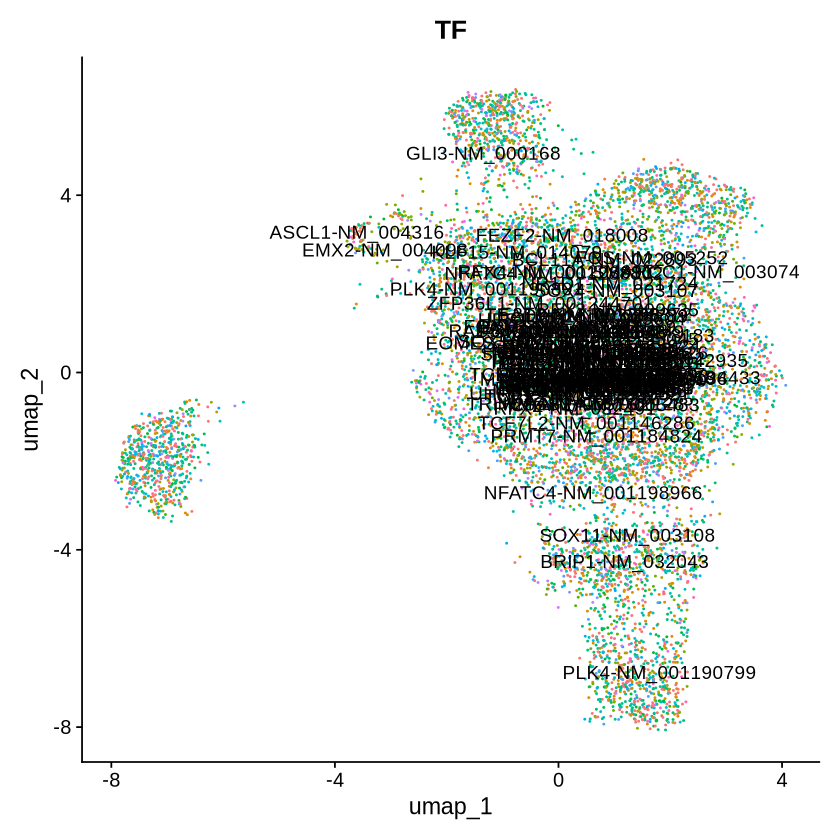

In [44]:
# 看看 UMAP 上每个 TF 的分布
DimPlot(seurat_TF_only, group.by = "TF", label = TRUE) + NoLegend()

In [49]:
# 看 指定 TF 如 "MAZ-NM_001276276"  的细胞在降维图上的分布
tf_cells <- subset(seurat_obj, subset = TF == "FOS-NM_005252 ")

# 画这个子集的 UMAP 图
DimPlot(tf_cells, label = TRUE)

Warning message:
“Removing 991 cells missing data for vars requested”


ERROR: [1m[33mError[39m in `subset()`:[22m
[33m![39m No cells found


Warning message:
“Removing 991 cells missing data for vars requested”
Warning message:
“Removing 991 cells missing data for vars requested”


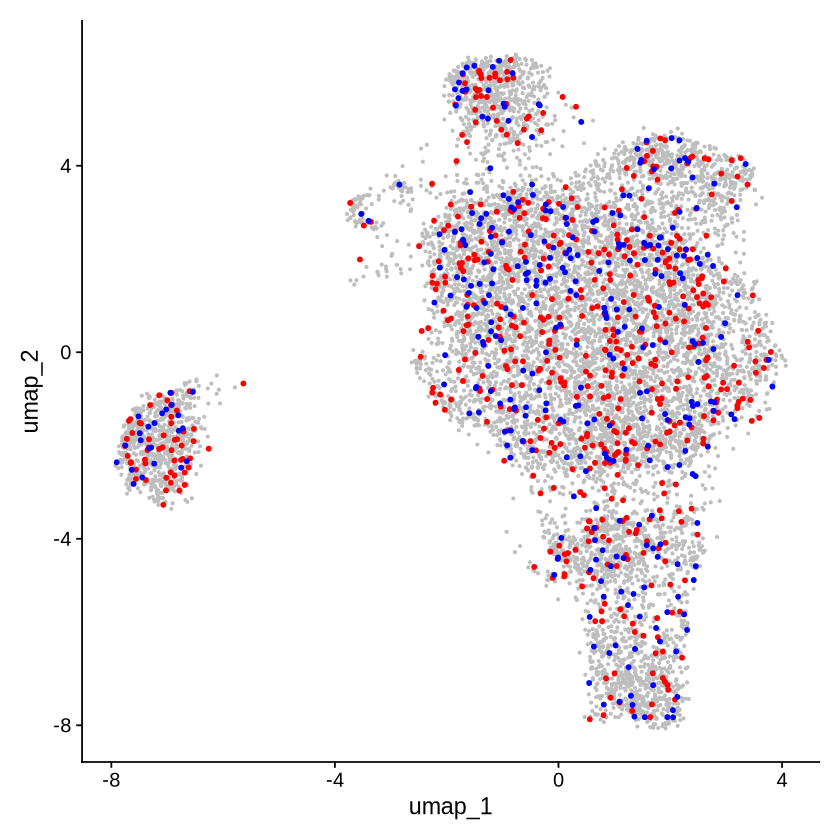

In [48]:
 # 整体图中只突出显示特定几个 TF 的细胞 如 "MAZ-NM_001276276" 和 "HES5-NM_001010926"
cells_maz <- WhichCells(seurat_obj, expression = TF == "MAZ-NM_001276276")
cells_hes5 <- WhichCells(seurat_obj, expression = TF == "HES5-NM_001010926")

DimPlot(seurat_obj, 
        cells.highlight = list(MAZ = cells_maz, HES5 = cells_hes5), 
        cols.highlight = c("red", "blue"), 
        cols = "grey", pt.size = 0.5) + NoLegend()

In [45]:
# 按MAZ-NM_001276276  TF 做差异分析
FindMarkers(seurat_TF_only, ident.1 = "MAZ-NM_001276276", group.by = "TF")

,p_val,avg_log2FC,pct.1,pct.2,p_val_adj
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ENSG00000101276,3.495465e-06,1.1520248,0.067,0.031,0.1177762
ENSG00000059377,1.133692e-05,1.4177217,0.044,0.018,0.3819863
ENSG00000223734,1.928320e-05,2.7866190,0.010,0.002,0.6497280
ENSG00000263571,2.298328e-05,2.2681513,0.012,0.002,0.7743987
ENSG00000176840,3.739475e-05,1.5799446,0.017,0.004,1.0000000
ENSG00000160124,6.513969e-05,0.3301073,0.374,0.296,1.0000000
ENSG00000273145,1.207615e-04,0.8011716,0.067,0.035,1.0000000
ENSG00000124003,1.765947e-04,2.7417062,0.012,0.003,1.0000000
ENSG00000254338,1.794002e-04,2.1019514,0.012,0.003,1.0000000
